In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Step 1: Load preprocessed data
train_data = pd.read_csv('preprocessed_train.csv')
test_data = pd.read_csv('preprocessed_test.csv')

# Step 2: Strip whitespace from column names
train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Step 3: Remove non-numeric or irrelevant columns
columns_to_remove = ['Breakfast Time', 'Lunch Time', 'CGM Data', 'Race', 'Viome']
train_data = train_data.drop(columns=columns_to_remove, errors='ignore')
test_data = test_data.drop(columns=columns_to_remove, errors='ignore')

# Step 4: Align train and test data columns
# Ensure train and test have the same feature columns
common_columns = [col for col in train_data.columns if col in test_data.columns]
train_data = train_data[common_columns + ['Lunch Calories']]  # Add target column back to train
test_data = test_data[common_columns]  # Test does not have 'Lunch Calories'

# Step 5: Define Dataset class for PyTorch
class MultimodalDataset(Dataset):
    def __init__(self, data, label_column=None):
        """
        Initialize the dataset with numeric data and optional label column.
        If label_column is None, this dataset is used for inference.
        """
        if label_column:
            self.labels = torch.tensor(data[label_column].values, dtype=torch.float32)
            self.features = torch.tensor(data.drop(columns=[label_column]).values, dtype=torch.float32)
        else:
            self.labels = None
            self.features = torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx]

# Step 6: Prepare DataLoaders
label_column = 'Lunch Calories'

# Training data includes labels
train_dataset = MultimodalDataset(train_data, label_column=label_column)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Testing data excludes labels
test_dataset = MultimodalDataset(test_data, label_column=None)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 7: Verify DataLoader
print("Training Dataset Size:", len(train_loader.dataset))
print("Testing Dataset Size:", len(test_loader.dataset))

# Example: Iterate through the Training DataLoader
for batch_idx, (features, labels) in enumerate(train_loader):
    print(f"Training Batch {batch_idx + 1}")
    print("Features:", features)
    print("Labels:", labels)
    break

# Example: Iterate through the Testing DataLoader
for batch_idx, features in enumerate(test_loader):
    print(f"Testing Batch {batch_idx + 1}")
    print("Features:", features)
    break

Training Dataset Size: 324
Testing Dataset Size: 73
Training Batch 1
Features: tensor([[ 4.9000e+01,  7.0000e+00,  4.4800e+02,  6.6000e+01,  1.0500e+01,
          2.2000e+01,  7.3785e-01,  1.0000e+00,  1.8605e-01, -1.2727e+00,
          3.0000e+00,  7.2000e+00,  1.4800e+02,  2.5200e+01,  1.2400e+02,
          1.4600e+02,  4.3000e+01,  1.0300e+02,  8.1000e+01,  2.5000e+01,
          3.4000e+00,  9.2089e+00,  8.5922e-01,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 2.6000e+01,  6.0000e+00,  2.6800e+02,  2.4000e+01,  1.0500e+01,
          2.2000e+01, -1.3835e+00,  0.0000e+00,  6.2598e-01,  8.7331e-01,
          2.0000e+00,  5.9000e+00,  1.0400e+02,  1.7800e+01,  1.5300e+02,
          1.7000e+02,  3.3000e+01,  1.3700e+02,  1.1000e+02,  3.1000e+01,
          5.2000e+00,  4.5709e+00,  6.6528e-02,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 4.4000e+01,  3.0000e+00,  6.0800e+02,  6.6000e+01,  1.0500e+01,
         

Epoch [1/500], Loss: 0.6187
Epoch [2/500], Loss: 0.3716
Epoch [3/500], Loss: 0.3705
Epoch [4/500], Loss: 0.3404
Epoch [5/500], Loss: 0.3192
Epoch [6/500], Loss: 0.3210
Epoch [7/500], Loss: 0.3046
Epoch [8/500], Loss: 0.3081
Epoch [9/500], Loss: 0.3020
Epoch [10/500], Loss: 0.2955
Epoch [11/500], Loss: 0.2966
Epoch [12/500], Loss: 0.2995
Epoch [13/500], Loss: 0.2838
Epoch [14/500], Loss: 0.2817
Epoch [15/500], Loss: 0.2803
Epoch [16/500], Loss: 0.2800
Epoch [17/500], Loss: 0.2690
Epoch [18/500], Loss: 0.2665
Epoch [19/500], Loss: 0.2724
Epoch [20/500], Loss: 0.2508
Epoch [21/500], Loss: 0.2578
Epoch [22/500], Loss: 0.2648
Epoch [23/500], Loss: 0.2528
Epoch [24/500], Loss: 0.2469
Epoch [25/500], Loss: 0.2373
Epoch [26/500], Loss: 0.2331
Epoch [27/500], Loss: 0.2435
Epoch [28/500], Loss: 0.2206
Epoch [29/500], Loss: 0.2194
Epoch [30/500], Loss: 0.2053
Epoch [31/500], Loss: 0.1990
Epoch [32/500], Loss: 0.2099
Epoch [33/500], Loss: 0.2007
Epoch [34/500], Loss: 0.1845
Epoch [35/500], Loss: 0

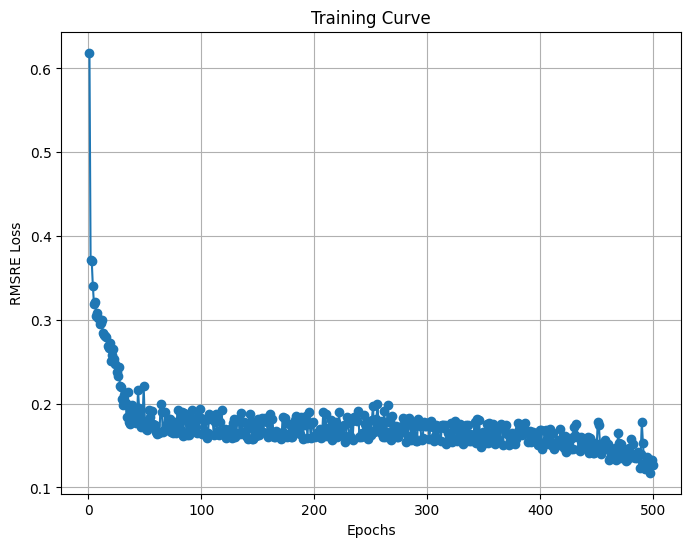

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Step 1: Define RMSRE Loss Function
class RMSRELoss(nn.Module):
    def __init__(self):
        super(RMSRELoss, self).__init__()

    def forward(self, predictions, targets):
        # Add epsilon to avoid division by zero
        epsilon = 1e-6
        relative_error = torch.log1p((predictions - targets).abs() / (targets.abs() + epsilon))
        return torch.sqrt(torch.mean(relative_error**2))

# Step 2: Define Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, joint_dim, output_dim):
        super(MultimodalModel, self).__init__()
        # Modality 1 Encoder
        self.modality1_encoder = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, joint_dim)
        )
        # Modality 2 Encoder
        self.modality2_encoder = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, joint_dim)
        )
        # Joint Prediction Layer
        self.joint_predictor = nn.Sequential(
            nn.Linear(joint_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # Split input into two modalities
        modality1, modality2 = torch.split(x, x.size(1) // 2, dim=1)
        # Encode each modality
        m1_embed = self.modality1_encoder(modality1)
        m2_embed = self.modality2_encoder(modality2)
        # Concatenate joint embedding
        joint_embedding = torch.cat([m1_embed, m2_embed], dim=1)
        # Predict target
        return self.joint_predictor(joint_embedding)

# Step 3: Model Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=500):
    model.train()
    train_loss = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for features, labels in train_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1))
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        train_loss.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    return train_loss

# Step 4: Visualize Training Curve
def plot_training_curve(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('RMSRE Loss')
    plt.title('Training Curve')
    plt.grid()
    plt.show()

# Step 5: Prepare Data and Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_loader.dataset.features.shape[1]
hidden_dim = 128
joint_dim = 64
output_dim = 1

# Initialize Model, Loss, and Optimizer
model = MultimodalModel(input_dim, hidden_dim, joint_dim, output_dim).to(device)
criterion = RMSRELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Step 6: Train the Model
epochs = 500
losses = train_model(model, train_loader, criterion, optimizer, epochs=epochs)

# Step 7: Plot Training Curve
plot_training_curve(losses)

In [10]:
import pandas as pd
import torch

# Step 1: Predict on Test Data
def predict_on_test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        for features in test_loader:
            features = features.to(device)
            outputs = model(features).squeeze(1)  # Remove extra dimension
            predictions.extend(outputs.cpu().numpy())
    return predictions

# Step 2: Generate Submission File
def generate_submission_file(predictions, output_path='submission.csv'):
    # Create a DataFrame in the required format
    submission = pd.DataFrame({
        'row_id': range(len(predictions)),  # Generate row IDs starting from 0
        'label': predictions  # Add predictions
    })
    submission.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")

# Step 3: Predict and Save Submission
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model and test_loader are defined
# model: The trained model
# test_loader: DataLoader for test data
predictions = predict_on_test(model, test_loader, device)
generate_submission_file(predictions, output_path='submission.csv')

Submission file saved to submission.csv
